# Evaluation

Evaluation of SVM and RandomForest using ROC Curves and Confussion Matrix

In [23]:
import csv
import numpy as np
from sklearn.preprocessing import scale, LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Display Helpers

Helpers to print graphically the ROC Curves and Confussion Matrix

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predecido')

    plt.show()


In [25]:
def print_roc(y_test, y_score, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    
    colors = itertools.cycle(['b', 'g', 'r', 'c', 'm'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Curva ROC de la clase {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ratio de Falso Positivo')
    plt.ylabel('Ratio de Verdadero Positivo')
    plt.title('Curvas ROC')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
movements = ['Recepcion', 'Levantada', 'Saque']

## Read Data

In [43]:
CSV_DELIMITER = ','

rootFolder = '/home/a20122064/data/TesisData/'
featuresFile = 'features-real.csv'
file = open(rootFolder + featuresFile, 'r', newline='')
reader = csv.reader(file, delimiter=CSV_DELIMITER)

data = np.array([row for row in reader])
file.close()
# print(data[data[:,2] > 0])

X = data[:,1:-1].astype(np.float) # ignore filename and class
X = X[X[:,-1] > 0] # ignore invalid data about speed

y = data[:,-1].astype(np.int)

y

array([1, 1, 2, 2, 1, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 2,
       2, 1, 3, 3, 2, 3, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 3, 3, 1, 1, 1,
       2, 2, 1, 3, 2, 3, 2, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 3, 2, 3, 2, 3, 1,
       1, 2, 1, 2, 2, 1, 2, 2, 1, 3, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 3, 2, 1, 2, 1, 3, 2, 3, 1, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 1, 2,
       2, 3, 3, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 3, 3, 2, 3, 3, 2,
       1, 2, 3, 3, 3, 1, 1, 2, 3, 1, 3, 1, 2, 1, 2, 3, 1, 3, 1, 2, 1, 2, 3,
       1, 3, 1, 1, 2, 1, 2, 2, 1, 2, 2, 3, 3, 1, 1, 3, 2, 3, 3, 2, 1, 1, 3,
       3, 2, 3, 1, 1, 3, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 2, 3, 3,
       3, 2, 1, 1, 2, 1, 2])

## Resample Data

We do this to make sure to keep the same proportion of elements in both train and test sets

In [28]:
def resampleData(X, y, test_size = 0.5):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    n_classes = len(le.classes_)
    
    samples = {}

    for c in range(n_classes):
        samples[c] = []

    for i, row in enumerate(X):
        samples[y[i]].append(row)

    X_train, X_test = [], []
    y_train, y_test = [], []

    for c in range(n_classes):
        matrix = np.matrix(samples[c])
        cutIndex = int(round(matrix.shape[0]*(1-test_size)))
        X_train += matrix[0:cutIndex].tolist()
        X_test += matrix[cutIndex:].tolist()
        y_train += [c] * cutIndex
        y_test += [c] * (matrix.shape[0] - cutIndex)

    return X_train, X_test, y_train, y_test


In [29]:
def dataInfo(X_train, X_test, y_train, y_test):
    print('Train set: {}'.format(len(X_train)))

    for (index, mov) in enumerate(movements):
        print('  {}: {}'.format(mov, np.array(X_train)[np.array(y_train) == index].shape[0]))

    print('Test set: {}'.format(len(X_test)))

    for (index, mov) in enumerate(movements):
        print('  {}: {}'.format(mov, np.array(X_test)[np.array(y_test) == index].shape[0]))
    

In [47]:
X_train, X_test, y_train, y_test = resampleData(X, y, test_size=0.3)

print(y_train, y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


## Tuning Hyperparameters

We perform a grid search for finding the best hyper parameters for the given dataset

In [31]:
def bestClf(model, X_train, X_test, y_train, y_test, parameters):
    dataInfo(X_train, X_test, y_train, y_test)

    clf = GridSearchCV(model, parameters)
    clf.fit(X_train, y_train)

    print(clf.best_params_)
    bestClf = clf.best_estimator_

    return bestClf


In [48]:
%%time

# bestSVM = bestClf(SVC(), X_train, X_test, y_train, y_test, {'kernel': ['rbf', 'linear'], 'C': np.logspace(-2, 2, 9), 'gamma': np.logspace(-4, 4, 9)})
bestRF = bestClf(RandomForestClassifier(), X_train, X_test, y_train, y_test, {'n_estimators': [20, 30, 40], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40], 'max_features': ['sqrt', 'log2']})
# bestXG = bestClf(GradientBoostingClassifier(), X_train, X_test, y_train, y_test, {'learning_rate': np.logspace(-2, 2, 9), 'n_estimators': [100, 200, 500], 'criterion': ['friedman_mse', 'mse', 'mae']})

Train set: 145
  Recepcion: 52
  Levantada: 52
  Saque: 41
Test set: 63
  Recepcion: 22
  Levantada: 23
  Saque: 18
{'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 20, 'max_depth': 20}
CPU times: user 11.6 s, sys: 8.31 ms, total: 11.6 s
Wall time: 11.6 s


## Testing

As we are testing two classifiers, it was to write a common function to test several classifiers

In [32]:
def testClassifier(model, X_train, X_test, y_train, y_test, name, prob_method):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    y_score = getattr(model, prob_method)(X_test)
    n_classes = y_score.shape[1]
    y_test_binarized =  label_binarize(y_test, range(n_classes))
    
    print_roc(y_test_binarized, y_score, movements)
    plot_confusion_matrix(confusion_matrix(y_test, y_predicted), movements, title=name + ' Norm', normalize=True)

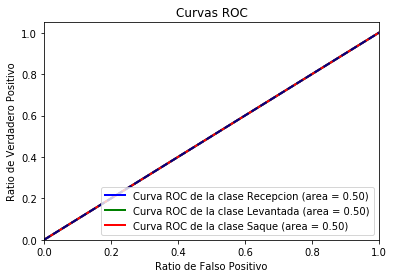

Matriz de confusión normalizada


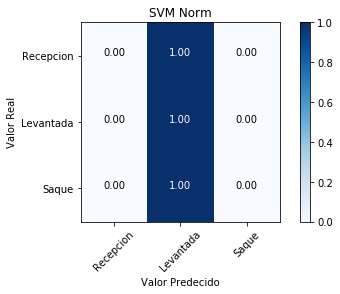

In [50]:
# Testing SVM

testClassifier(SVC(C=10.0, gamma=0.01, kernel='rbf'), X_train, X_test, y_train, y_test, 'SVM', 'decision_function')

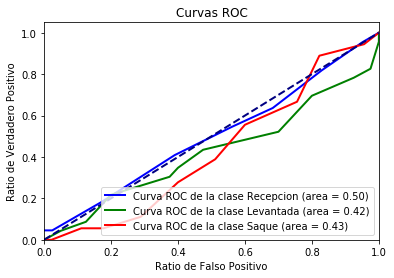

Matriz de confusión normalizada


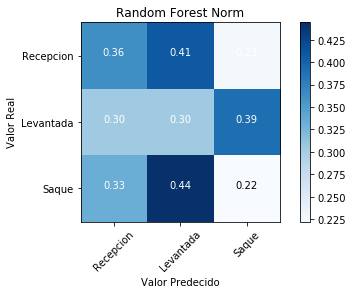

In [49]:
# Testing RF

testClassifier(bestRF, X_train, X_test, y_train, y_test, 'Random Forest', 'predict_proba')

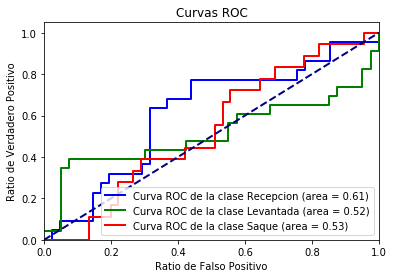

Matriz de confusión normalizada


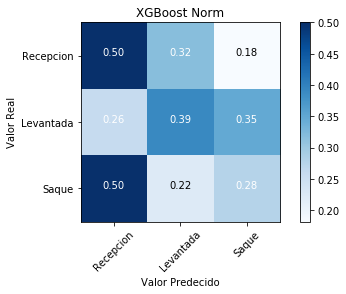

In [51]:
# Testing RF

testClassifier(GradientBoostingClassifier(), X_train, X_test, y_train, y_test, 'XGBoost', 'predict_proba')